In [2]:
# %%
from functools import partial
from os import walk
import time

import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
import tensorflow as tf

/home/lshi23/anaconda3/envs/badgr/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/lshi23/anaconda3/envs/badgr/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/lshi23/anaconda3/envs/badgr/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/lshi23/anaconda3/envs/badgr/lib/python3.6/s

In [3]:
# %%
tf.compat.v1.enable_eager_execution()
OWNENV = False  # whether use own data
COLLISION = True  # collision or bumpy data

In [4]:
# %%
if OWNENV:
    # files = ['../data/circles/21-03-17/16-59-30.tfrecord']
    files = ['../data/test/depth/001.tfrecord']
else:
    files = []
    path = '/home/lshi23/badgr/data/tfrecords_collision/' if COLLISION else '/home/lshi23/badgr/data/tfrecords_bumpy'
    for dirpath, dirnames, filenames in walk(path):
        for filename in filenames:
            if filename.endswith('tfrecord'):
                files.append(dirpath+'/'+filename)
    files.sort()

    # Only one file for testing
    # files = ['../../badgr/data/tfrecords_collision/08-02-2019_horizon_8/0000.tfrecord'] \
    #     if COLLISION else ['../../badgr/data/tfrecords_bumpy/08-02-2019_horizon_8/0000.tfrecord']

print(f'File numbers: {len(files)}')
# print(files)
raw_dataset = tf.data.TFRecordDataset(files)

File numbers: 4859


In [5]:
# %%
if OWNENV:
    names_shapes_limits_dtypes = (
        ('images/rgb_left', (96, 128, 3), (0, 255), np.uint8),
        ('collision/close', (1, ), (0, 1), np.bool),
        ('jackal/position', (3, ), (-0.5, 0.5), np.float32),
        ('jackal/yaw', (1, ), (-np.pi, np.pi), np.float32),
        ('commands/angular_velocity', (1, ), (-1.0, 1.0), np.float32),
        ('commands/linear_velocity', (1, ), (0.75, 1.25), np.float32)
    )
    collision_names = [
        'images/rgb_left',
        'jackal/position',
        'jackal/yaw',
        'collision/close',
    ]
    action_names = ['commands/angular_velocity', 'commands/linear_velocity']
    names = collision_names
else:
    names_shapes_limits_dtypes = (
        ('images/rgb_left', (96, 128, 3), (0, 255), np.uint8),
        ('images/rgb_right', (96, 128, 3), (0, 255), np.uint8),
        ('images/thermal', (32, 32), (-1, 1), np.float32),
        ('lidar', (360, ), (0., 12.), np.float32),
        ('collision/close', (1, ), (0, 1), np.bool),
        ('collision/flipped', (1, ), (0, 1), np.bool),
        ('collision/stuck', (1, ), (0, 1), np.bool),
        ('collision/any', (1, ), (0, 1), np.bool),
        ('gps/is_fixed', (1, ), (0, 1), np.float32),
        ('gps/latlong', (2, ), (0, 1), np.float32),
        ('gps/utm', (2, ), (0, 1), np.float32),
        ('imu/angular_velocity', (3, ), (-1.0 * np.pi, 1.0 * np.pi), np.float32),
        ('imu/compass_bearing', (1, ), (-np.pi, np.pi), np.float32),
        ('imu/linear_acceleration', (3, ), ((-1., -1., 9.81 - 1.), (1., 1., 9.81 + 1.)), np.float32),
        ('jackal/angular_velocity', (1, ), (-1.0 * np.pi, 1.0 * np.pi), np.float32),
        ('jackal/linear_velocity', (1, ), (-1., 1.), np.float32),
        ('jackal/imu/angular_velocity', (3, ), (-1.0 * np.pi, 1.0 * np.pi), np.float32),
        ('jackal/imu/linear_acceleration', (3, ), ((-1., -1., 9.81 - 1.), (1., 1., 9.81 + 1.)), np.float32),
        ('jackal/position', (3, ), (-0.5, 0.5), np.float32),
        ('jackal/yaw', (1, ), (-np.pi, np.pi), np.float32),
        ('android/illuminance', (1, ), (0., 200.), np.float32),
        ('bumpy', (1, ), (0, 1), np.bool),
        ('commands/angular_velocity', (1, ), (-1.0, 1.0), np.float32),
        ('commands/linear_velocity', (1, ), (0.75, 1.25), np.float32)
    )
    collision_names = [
        'images/rgb_left',
        'jackal/position',
        'jackal/yaw',
        'jackal/angular_velocity',
        'jackal/linear_velocity',
        'jackal/imu/angular_velocity',
        'jackal/imu/linear_acceleration',
        'imu/angular_velocity',
        'imu/linear_acceleration',
        'imu/compass_bearing',
        'gps/latlong',
        'collision/close',
        'collision/stuck',
    ]
    bumpy_names = [
        'images/rgb_left',
        'jackal/imu/angular_velocity',
        'jackal/imu/linear_acceleration',
        'imu/angular_velocity',
        'imu/linear_acceleration',
        'bumpy',
    ]
    action_names = ['commands/angular_velocity', 'commands/linear_velocity']
    names = collision_names if COLLISION else bumpy_names

names_to_dtypes = {}
names_to_shapes = {}
names_to_limits = {}
for name, shape, limit, dtype in names_shapes_limits_dtypes:
    names_to_dtypes[name] = dtype
    names_to_shapes[name] = shape
    names_to_limits[name] = limit


def get_names_dtypes_shapes(observation_names, action_names):
    env = dict()
    names = ['inputs/' + name for name in observation_names + action_names] + \
            ['outputs/' + name for name in observation_names if 'rgb' not in name]
    dtypes = [tf.dtypes.as_dtype(names_to_dtypes[name.replace('inputs/', '').replace('outputs/', '')]) for name in names]
    dtypes = [dtype if dtype != tf.bool else tf.uint8 for dtype in dtypes]
    shapes = []
    for name in names:
        name_suffix = name.replace('inputs/', '').replace('outputs/', '')
        shape = list(names_to_shapes[name_suffix])
        if name.startswith('outputs/') or name_suffix in action_names:
            shape = [8] + shape
        shapes.append(shape)

    names.append('outputs/done')
    dtypes.append(tf.uint8)
    shapes.append((8, ))

    env['names'] = names
    env['dtypes'] = dtypes
    env['shapes'] = shapes

    return env


env = get_names_dtypes_shapes(names, action_names)

In [6]:
# %%
def parse_fn(data):
    parsed = tf.parse_single_example(data, {name: tf.FixedLenFeature([], tf.string) for name in env['names']})
    decode_parsed = {name: tf.decode_raw(parsed[name], dtype) for name, dtype in zip(env['names'], env['dtypes'])}
    reshape_decode_parsed = dict()
    for name, shape in zip(env['names'], env['shapes']):
        tensor = decode_parsed[name]
        tensor.set_shape([np.prod(shape)])
        tensor = tf.reshape(tensor, shape)
        reshape_decode_parsed[name] = tensor

    # NOTE: randomize actions after done
    # done_float = tf.cast(reshape_decode_parsed['outputs/done'], tf.float32)[:, tf.newaxis]
    # for name in action_names:
    #     lower, upper = names_to_limits[name]
    #     shape = names_to_shapes[name]
    #     action = reshape_decode_parsed['inputs/' + name]
    #     horizon = action.shape[0].value
    #     action = (1 - done_float) * action + done_float * \
    #         tf.random.uniform(shape=[horizon] + list(shape),
    #                           minval=lower, maxval=upper)
    #     reshape_decode_parsed['inputs/' + name] = action
    return reshape_decode_parsed

In [7]:
# %%
def commands_to_positions(linvel, angvel):
    dt = 0.25
    N = len(linvel)
    all_angles = [np.zeros(N)]
    all_positions = [np.zeros((N, 2))]
    for linvel_i, angvel_i in zip(linvel.T, angvel.T):
        angle_i = all_angles[-1] + dt * angvel_i
        position_i = all_positions[-1] + \
                     dt * linvel_i[..., np.newaxis] * np.stack([np.cos(angle_i), np.sin(angle_i)], axis=1)

        all_angles.append(angle_i)
        all_positions.append(position_i)

    all_positions = np.stack(all_positions, axis=1)
    return all_positions


def rotate_to_global(pos, yaw):
    R = np.array([[np.cos(yaw), -np.sin(yaw), 0.],
                  [np.sin(yaw), np.cos(yaw), 0.],
                  [0., 0., 1.]])
    pos = np.hstack((pos, np.zeros([len(pos), 1])))

    positions_in_origin = (pos - pos[0]).dot(R)[:, :2]

    return positions_in_origin

In [8]:
# %%
dataset = raw_dataset.map(parse_fn, num_parallel_calls=6)
# dataset = dataset.filter(lambda x: tf.reduce_any(
#     tf.cast(x['outputs/collision/close'], tf.bool)
# ))
# dataset = dataset.batch(2)
# iterator = dataset.make_one_shot_iterator()

-----collsion-----
[0]
[0]
[0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0]
-----position & yaw-----
[ 78.62185 -87.19711   0.     ]
[[ 78.69221  -87.356964   0.      ]
 [ 78.74635  -87.493546   0.      ]
 [ 78.79971  -87.660355   0.      ]
 [ 78.85294  -87.83151    0.      ]
 [ 78.89866  -87.99216    0.      ]
 [ 78.947136 -88.173904   0.      ]
 [ 78.972946 -88.36138    0.      ]
 [ 78.98728  -88.524956   0.      ]]
[-1.1128368]
[-1.1213727 -1.189469  -1.2952567 -1.3111644 -1.3080657 -1.316065
 -1.4616433 -1.5391979]
-----velocity-----
tf.Tensor([0.6438024], shape=(1,), dtype=float32)
tf.Tensor(
[[0.59898496]
 [0.6111729 ]
 [0.646954  ]
 [0.6312007 ]
 [0.61074084]
 [0.63910186]
 [0.66985327]
 [0.67837596]], shape=(8, 1), dtype=float32)
tf.Tensor([0.31119728], shape=(1,), dtype=float32)
tf.Tensor(
[[-0.02033384]
 [-0.16572602]
 [-0.35175762]
 [-0.07040735]
 [-0.04500778]
 [-0.02888484]
 [-0.44018924]
 [-0.3012368 ]], shape=(8, 1), dtype=float32)
-----cmd-----
[0.64158225 0.64158225 0.64158225 0.64

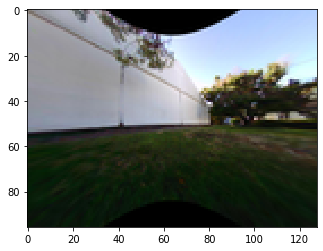

-----collsion-----
[0]
[0]
[0 0 0 0 0 0 1 0]
[0 0 0 0 0 0 0 0]
-----position & yaw-----
[ 74.54599  -94.638885   0.      ]
[[ 74.557106 -94.47347    0.      ]
 [ 74.581696 -94.30331    0.      ]
 [ 74.626076 -94.15233    0.      ]
 [ 74.68679  -94.00855    0.      ]
 [ 74.75643  -93.835266   0.      ]
 [ 74.8366   -93.686424   0.      ]
 [ 74.90452  -93.57424    0.      ]
 [ 75.02753  -93.51215    0.      ]]
[1.4744985]
[ 1.5433637  1.4373678  1.23511    1.0802143  1.1325667  1.0652857
  0.9980564 -1.7125235]
-----velocity-----
tf.Tensor([0.5950309], shape=(1,), dtype=float32)
tf.Tensor(
[[0.5698213 ]
 [0.5728246 ]
 [0.6094987 ]
 [0.5668517 ]
 [0.5938648 ]
 [0.55410224]
 [0.5718344 ]
 [0.53812546]], shape=(8, 1), dtype=float32)
tf.Tensor([0.2949919], shape=(1,), dtype=float32)
tf.Tensor(
[[ 0.21899894]
 [-0.2579416 ]
 [-0.6347975 ]
 [-0.54665256]
 [ 0.02038169]
 [-0.21003942]
 [-0.25313324]
 [-0.4953843 ]], shape=(8, 1), dtype=float32)
-----cmd-----
[0.59032035 0.59032035 0.59032035 0.

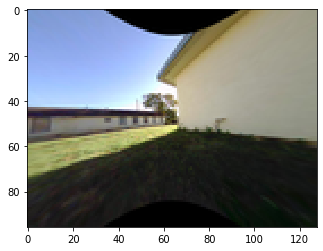

-----collsion-----
[0]
[0]
[0 1 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0]
-----position & yaw-----
[ 77.62006 -88.43504   0.     ]
[[ 77.45324  -88.38407    0.      ]
 [ 77.3444   -88.36117    0.      ]
 [ 77.22841  -88.371056   0.      ]
 [ 77.396645 -88.36796    0.      ]
 [ 77.54063  -88.36069    0.      ]
 [ 77.67626  -88.335434   0.      ]
 [ 77.81019  -88.29389    0.      ]
 [ 77.95258  -88.24707    0.      ]]
[2.8076625]
[ 2.8633633   2.9430833  -0.05646071  0.10429665  0.10760228  0.20935038
  0.34977707  0.37385273]
-----velocity-----
tf.Tensor([0.6504418], shape=(1,), dtype=float32)
tf.Tensor(
[[0.66044396]
 [0.60373056]
 [0.4314614 ]
 [0.5284323 ]
 [0.5176453 ]
 [0.5176773 ]
 [0.5041883 ]
 [0.5042348 ]], shape=(8, 1), dtype=float32)
tf.Tensor([0.12563053], shape=(1,), dtype=float32)
tf.Tensor(
[[0.19600064]
 [0.36014536]
 [0.4449533 ]
 [0.4997704 ]
 [0.11876851]
 [0.34457353]
 [0.43292636]
 [0.13321996]], shape=(8, 1), dtype=float32)
-----cmd-----
[0.66284007 0.66284007 0.515696   0.51

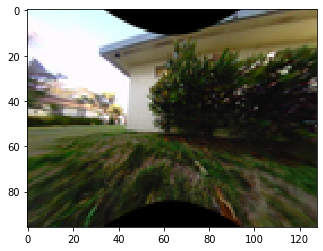

-----collsion-----
[0]
[0]
[0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0]
-----position & yaw-----
[ 87.38419  -28.246275   0.      ]
[[ 87.209785 -28.248852   0.      ]
 [ 86.9996   -28.27001    0.      ]
 [ 86.82152  -28.280493   0.      ]
 [ 86.64284  -28.272612   0.      ]
 [ 86.44699  -28.262127   0.      ]
 [ 86.222786 -28.212032   0.      ]
 [ 86.03244  -28.129124   0.      ]
 [ 85.88109  -28.03174    0.      ]]
[-3.130649]
[-3.048953  -2.9842992 -3.0566454  3.0691724  3.0290725  2.86367
  2.634798   2.4689763]
-----velocity-----
tf.Tensor([0.66883147], shape=(1,), dtype=float32)
tf.Tensor(
[[0.6945947 ]
 [0.6682727 ]
 [0.62583864]
 [0.66196984]
 [0.7158282 ]
 [0.70998025]
 [0.67383367]
 [0.6496356 ]], shape=(8, 1), dtype=float32)
tf.Tensor([0.5770177], shape=(1,), dtype=float32)
tf.Tensor(
[[ 0.36167163]
 [ 0.25608504]
 [-0.17767185]
 [-0.43636748]
 [-0.1917282 ]
 [-0.5015107 ]
 [-0.6694267 ]
 [-0.605926  ]], shape=(8, 1), dtype=float32)
-----cmd-----
[0.64505 0.64505 0.64505 0.64505 0.64

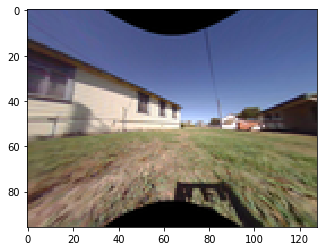

Total data number: 4
Close number: 0
Time elapsed: 0.5264496803283691


In [13]:
# %%
start_time = time.time()
count = 0
count_close = 0
count_img = 0
for data in dataset:
    if count > 3:
        break
    # print(data)

    # if data['outputs/collision/close'].numpy().sum() > 0.5:
    #     count_close += 1
    #     continue
    # if data['outputs/done'].numpy().sum() < 0.5:
    #     continue
    # if data['outputs/bumpy'].numpy().sum() < 0.5:
    #     continue
    count += 1

    print('-----collsion-----')
    print(data['inputs/collision/close'].numpy())
    print(data['inputs/collision/stuck'].numpy())
    print(data['outputs/collision/close'].numpy().flatten())
    print(data['outputs/collision/stuck'].numpy().flatten())

    print('-----position & yaw-----')
    pos_in = data['inputs/jackal/position'].numpy()
    pos_out = data['outputs/jackal/position'].numpy()
    print(pos_in)
    print(pos_out)
    yaw_in = data['inputs/jackal/yaw'].numpy()
    yaw_out = data['outputs/jackal/yaw'].numpy()
    print(yaw_in)
    print(yaw_out.flatten())

    print('-----velocity-----')
    print(data['inputs/jackal/linear_velocity'])
    print(data['outputs/jackal/linear_velocity'])
    print(data['inputs/jackal/angular_velocity'])
    print(data['outputs/jackal/angular_velocity'])

    print('-----cmd-----')
    linvel = data['inputs/commands/linear_velocity'].numpy()
    angvel = data['inputs/commands/angular_velocity'].numpy()
    print(linvel.flatten())
    print(angvel.flatten())

    print('-----done-----')
    print(data['outputs/done'].numpy())

    # compass_bearing = data['inputs/imu/compass_bearing'].numpy()[0]
    # yaw = compass_bearing - 0.5 * np.pi  # so that east is 0 degrees

    pos = commands_to_positions(linvel.reshape(-1, 8), angvel.reshape(-1, 8))
    pos = pos[0]
    pos_global = rotate_to_global(pos, -yaw_in[0])
    pos_global += pos_in[:2]

    # print('-----compass-----')
    # print(compass_bearing)
    print('-----predict-----')
    print(pos_global)
    print(np.linalg.norm(pos_global[1:]-pos_out[:, :2]))

    # jak_lin_acc = data['outputs/jackal/imu/linear_acceleration'].numpy()
    # jak_ang_vel = data['outputs/jackal/imu/angular_velocity'].numpy()
    # lin_acc = data['outputs/imu/linear_acceleration'].numpy()
    # ang_vel = data['outputs/imu/angular_velocity'].numpy()

    # bumpy = data['outputs/bumpy'].numpy()

    # print(np.stack((bumpy.flatten(),
    #                 np.linalg.norm(jak_ang_vel, axis=1),
    #                 np.linalg.norm(ang_vel, axis=1)), axis=-1))

    if count_img < 100:
        img = data['inputs/images/rgb_left'].numpy()
        img = Image.fromarray(img)
        # img.save(f'../result/img/{count}.png')
        plt.imshow(img, interpolation='nearest')
        plt.show()
    count_img += 1

print(f'Total data number: {count}')
print(f'Close number: {count_close}')
print(f'Time elapsed: {time.time() - start_time}')

-----collsion-----
[0]
[0 0 0 0 0 0 0 0]
-----position & yaw-----
[ 78.62185 -87.19711   0.     ]
[[ 78.69221  -87.356964   0.      ]
 [ 78.74635  -87.493546   0.      ]
 [ 78.79971  -87.660355   0.      ]
 [ 78.85294  -87.83151    0.      ]
 [ 78.89866  -87.99216    0.      ]
 [ 78.947136 -88.173904   0.      ]
 [ 78.972946 -88.36138    0.      ]
 [ 78.98728  -88.524956   0.      ]]
[-1.1128368]
[-1.1213727 -1.189469  -1.2952567 -1.3111644 -1.3080657 -1.316065
 -1.4616433 -1.5391979]
-----cmd-----
[0.64158225 0.64158225 0.64158225 0.64158225 0.64158225 0.64158225
 0.64158225 0.64158225]
[ 0.06955008 -0.95277584  0.44306728 -0.29633158  0.16738565 -0.9964289
  0.40204123  0.4734469 ]
-----done-----
[0 0 0 0 0 0 0 0]


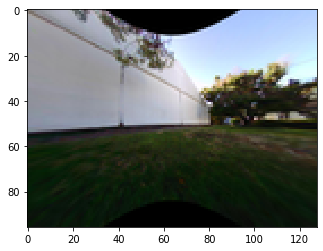

In [14]:
# %%
for data in dataset.take(1):
    # if data['outputs/collision/close'].numpy().sum() > 0.5:
    #     continue
    # if data['outputs/done'].numpy().sum() < 0.5:
    #     continue
    print('-----collsion-----')
    print(data['inputs/collision/close'].numpy())
    print(data['outputs/collision/close'].numpy().flatten())

    print('-----position & yaw-----')
    print(data['inputs/jackal/position'].numpy())
    print(data['outputs/jackal/position'].numpy())
    print(data['inputs/jackal/yaw'].numpy())
    print(data['outputs/jackal/yaw'].numpy().flatten())

    # print('-----cmd-----')
    # print(data['inputs/commands/linear_velocity'])
    # print(data['inputs/commands/angular_velocity'])

    print('-----cmd-----')
    print(data['inputs/commands/linear_velocity'].numpy().flatten())
    print(data['inputs/commands/angular_velocity'].numpy().flatten())

    print('-----done-----')
    print(data['outputs/done'].numpy())

    img = data['inputs/images/rgb_left'].numpy()
    plt.imshow(img, interpolation='nearest')
    plt.show()

In [ ]:
# %% Bumpy
for data in dataset.take(1):
    img = data['inputs/images/rgb_left'].numpy()
    plt.imshow(img, interpolation='nearest')
    plt.show()

    print('-----bumpy-----')
    print(data['inputs/bumpy'].numpy())
    print(data['outputs/bumpy'].numpy().flatten())

    print('-----angular_velocity-----')
    print(data['inputs/jackal/imu/angular_velocity'].numpy())
    print(data['outputs/jackal/imu/angular_velocity'].numpy())

    print('-----linear_acceleration-----')
    print(data['inputs/jackal/imu/linear_acceleration'].numpy())
    print(data['outputs/jackal/imu/linear_acceleration'].numpy())

    print('-----imu_angular_velocity-----')
    print(data['inputs/imu/angular_velocity'].numpy())
    print(data['outputs/imu/angular_velocity'].numpy())

    print('-----imu_linear_acceleration-----')
    print(data['inputs/imu/linear_acceleration'].numpy())
    print(data['outputs/imu/linear_acceleration'].numpy())

In [ ]:
# %%
num, bumpy_num, even_num, partial_num = 0, 0, 0, 0
for data in dataset:
    num += 1
    bumpy = data['outputs/bumpy'].numpy().sum()
    if bumpy == 8:
        bumpy_num += 1
    elif bumpy == 0:
        even_num += 1
    else:
        partial_num += 1

print(f'Total num: {num}\n',
      f'Bumpy num: {bumpy_num}\n',
      f'Even num: {even_num}\n',
      f'Partial num: {partial_num}')